# Introduction to reranking: an advanced RAG technique

In this notebook, you will test an advanced RAG technique: using a reranker (CrossEncoder model) to improve the retrieval of news in a RAG pipeline.

The notebook is partially filled with code. You will complete it by writing the missing code, running evaluations, and comparing results.

# 📌 Objectives

By the end of this notebook, students will be able to:

1. **Create and Use a Synthetic Evaluation Dataset:**
   - Automatically generate natural language questions corresponding to news articles using an LLM.
   - Construct a test set to assess the quality of retrieved answers.

2. **Evaluate Baseline RAG Performance Without Reranking:**
   - Measure how often the original article appears in the top-k results using FAISS alone.
   - Record retrieval accuracy and position for each query.

3. **Apply a Cross-Encoder Reranker to Improve Retrieval:**
   - Use a pretrained CrossEncoder model to rerank top FAISS results.
   - Evaluate improvements in the ranking of correct articles after reranking.

4. **Compare Retrieval Performance With and Without Reranking:**
   - Compute and visualize differences in rank positions before and after reranking.
   - Analyze statistical improvements (e.g., average rank, frequency at position 0).

5. **Reflect on the Impact of Reranking in RAG Pipelines:**
   - Discuss how reranking enhances retrieval quality in a RAG context.
   - Identify scenarios where reranking may offer the most value, and propose further improvements.


## Install and Import librairies
Run the following cell to install required libraries. These include `sentence-transformers` for embeddings and reranking, and `faiss-cpu` for vector similarity search.

In [2]:
%pip install sentence-transformers
%pip install faiss-gpu

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu


In [3]:
from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import faiss


## Load S&P 500 news
We will work with a dataset of financial news headlines and summaries. You will:
 - Load the data
 - Convert the publication date column to datetime
 - Drop duplicate summaries

In [4]:
df_news = pd.read_csv('df_news.csv')
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
display(df_news)
print(df_news.shape)

df_news.drop_duplicates('SUMMARY', inplace=True)
print(df_news.shape)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


(4871, 6)
(3976, 6)


## Implement a Faiss Vector Store with Sentence Transfomer embeddings
This section is already implemented. It uses a sentence transformer to encode news summaries into vector embeddings and stores them in a FAISS index.
 
We also define a simple class `FaissVectorStore` that allows for efficient retrieval.


In [5]:
df_news['EMBEDDED_TEXT'] = df_news['TITLE'] + ' : ' + df_news['SUMMARY']

In [6]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [7]:
# Load model and compute embeddings
text_embeddings = model.encode(df_news['SUMMARY'].tolist(), convert_to_numpy=True)

# Normalize embeddings to use cosine similarity (via inner product in FAISS)
text_embeddings = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)

# Prepare metadata
documents = df_news['SUMMARY'].tolist()
metadata = [
    {
        'PUBLICATION_DATE': row['PUBLICATION_DATE'], 
        'TICKER': row['TICKER'], 
        'PROVIDER': row['PROVIDER']
    }
    for _, row in df_news.iterrows()
]

In [8]:
embedding_dim = text_embeddings.shape[1]
faiss_index = faiss.IndexFlatIP(embedding_dim)  # Cosine similarity via inner product
faiss_index.add(text_embeddings)

In [9]:
class FaissVectorStore:
    def __init__(self, model, index, embeddings, documents, metadata):
        self.model = model
        self.index = index
        self.embeddings = embeddings
        self.documents = documents
        self.metadata = metadata

    def search(self, query, k=5, metadata_filter=None):
        query_embedding = self.model.encode([query])
        query_embedding = query_embedding / np.linalg.norm(query_embedding)

        if metadata_filter:
            filtered_indices = [i for i, meta in enumerate(self.metadata) if metadata_filter(meta)]
            if not filtered_indices:
                return []
            filtered_embeddings = self.embeddings[filtered_indices]
            temp_index = faiss.IndexFlatIP(filtered_embeddings.shape[1])
            temp_index.add(filtered_embeddings)
            D, I = temp_index.search(query_embedding, k)
            indices = [filtered_indices[i] for i in I[0]]
        else:
            D, I = self.index.search(query_embedding, k)
            indices = I[0]
            D = D[0]

        results = []
        for idx, sim in zip(indices, D):
            results.append((self.documents[idx], self.metadata[idx], float(sim)))


        return results

In [10]:
# Create FAISS-based store
faiss_store = FaissVectorStore(
    model=model,
    index=faiss_index,
    embeddings=text_embeddings,
    documents=documents,
    metadata=metadata
)

## Creating a dataset to evaluate the reranking

👉 **Instructions**:
- In this section, we will create an evaluation dataset for reranking by:
  - Sampling **100** distinct news articles from the full dataset.
  - Generating **one natural question** per article using GPT, where the expected answer is the original article.

✅ By the end of this section, you'll have a new DataFrame (`df_news_questions`) with:
- `NEWS`: the original summary
- `QUESTION`: the corresponding question generated using GPT

> ℹ️ The generated questions will simulate user queries in a RAG pipeline.

In [11]:
from openai import OpenAI
import time
import pandas as pd
from sk import my_sk   # IMPORT SECRET KEY FROM sk.py FILE

# 100 SAMPLES FROM THE FULL DATASET
sampled_df = df_news.sample(n=100, random_state=42).copy()
sampled_df.reset_index(drop=True, inplace=True)

# INITIALIZE        
sampled_df['QUESTION'] = ''


### Create OpenAI connector
You’ll use OpenAI’s GPT model to generate natural questions corresponding to each sampled news summary. These questions will be used to test the retrieval system.

✅ This cell contains an API key for demonstration purposes. You **must** use your own API key when running this notebook.


In [12]:
from openai import OpenAI
client = OpenAI(api_key = my_sk)

response = client.responses.create(
    model="gpt-4o-mini",
    input="Write a one-sentence bedtime story about a unicorn."
)

print(response.output_text)

Under the twinkling stars, a gentle unicorn named Luna spread her shimmering wings and soared through the moonlit sky, sprinkling stardust dreams on all sleeping children below.


### Using GPT to generate a question based on a news
Based on the instruction above, you need to use GPT to create a evaluation dataset. 

**Clarification** Specifically, the goal is to generate a natural question whose correct answer is the news summary. For example, if the news is about a company announcing layoffs, a good question could be: ‘Which company recently announced job cuts in its tech division?


In [13]:
prompt = """
Given the news headline provided below, 
give me a question that would justify retrieving this specific news headline in a RAG system

News headlines:
{news}

Give me a question for which the answer is the news headline:
QUESTION

**Important**
dont answer anything else other than the question!
"""

In [14]:
# Generate questions for each summary
for i, summary in enumerate(sampled_df['SUMMARY']):
    try:
        response = client.chat.completions.create(
            model="gpt-4o",  # Use gpt-4o for better performance
            messages=[
                {"role": "system", "content": prompt},
                #{"role": "user", "content": f"Resumen: {summary}\n\nPregunta:"}
                {"role": "user", "content": f"Summary: {summary}\n\nQuestion:"}
            ]
        )
        question = response.choices[0].message.content.strip()
        sampled_df.at[i, 'QUESTION'] = question
        print(f"[{i+1}/100] Generated Question.")
        time.sleep(1.2)  # for good luck, avoid rate limits
    except Exception as e:
        print(f"[{i+1}/100] Error: {e}")
        sampled_df.at[i, 'QUESTION'] = '[ERROR]'

df_news_questions = sampled_df[['SUMMARY', 'QUESTION']]
df_news_questions.rename(columns={'SUMMARY': 'NEWS'}, inplace=True)
df_news_questions.to_csv("df_news_questions.csv", index=False)

[1/100] Generated Question.
[2/100] Generated Question.
[3/100] Generated Question.
[4/100] Generated Question.
[5/100] Generated Question.
[6/100] Generated Question.
[7/100] Generated Question.
[8/100] Generated Question.
[9/100] Generated Question.
[10/100] Generated Question.
[11/100] Generated Question.
[12/100] Generated Question.
[13/100] Generated Question.
[14/100] Generated Question.
[15/100] Generated Question.
[16/100] Generated Question.
[17/100] Generated Question.
[18/100] Generated Question.
[19/100] Generated Question.
[20/100] Generated Question.
[21/100] Generated Question.
[22/100] Generated Question.
[23/100] Generated Question.
[24/100] Generated Question.
[25/100] Generated Question.
[26/100] Generated Question.
[27/100] Generated Question.
[28/100] Generated Question.
[29/100] Generated Question.
[30/100] Generated Question.
[31/100] Generated Question.
[32/100] Generated Question.
[33/100] Generated Question.
[34/100] Generated Question.
[35/100] Generated Ques

C:\Users\esteb\AppData\Local\Temp\ipykernel_29176\2336030934.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news_questions.rename(columns={'SUMMARY': 'NEWS'}, inplace=True)


In [15]:
display(df_news_questions)

,NEWS,QUESTION
0,"Broadcom, Arista Networks initiated: Wall Stre...",Which companies were recently initiated by Wal...
1,Emerson Electric (EMR) has received quite a bi...,What recent news involving Emerson Electric (E...
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What are the implications of Ventas (VTR) repo...
3,Nvidia's earnings call this week will be a mar...,What are the key takeaways to consider from Nv...
4,Inflation-scarred American consumers are putti...,Why are inflation-scarred American consumers w...
...,...,...
95,T. Rowe Price Group ( NASDAQ:TROW ) First Quar...,What were the key financial results for T. Row...
96,"Heartland Advisors, an investment management c...","What were the returns of Heartland Advisors' ""..."
97,Key Insights Given the large stake in the stoc...,What is the potential vulnerability of Phillip...
98,The study found that early intervention led to...,What did the study find about the impact of ea...


## Evaluating RAG without and with reranking

You will now compare a basic RAG pipeline using FAISS with an enhanced version that includes reranking.


### RAG without reranking

👉 **Instructions**:
1. Implement a function that retrieves the **top 5** news summaries for a given question using your FAISS vector store.
2. For each `(QUESTION, NEWS)` pair:
   - Search using the `QUESTION`
   - Check if the corresponding `NEWS` appears in the top 5 retrieved summaries.
   - Record the **rank position** (from 0 to 4) in a new column `NO_RERANKER`.
   - If the news is **not found**, store `'not found'`.

✅ This step helps measure the baseline performance of your vector-based retrieval without reranking.

> 💡 Tip: You can store the retrieved results in a dictionary or list to avoid recomputation.

In [16]:
# Baseline evaluation function without reranker

def evaluate_no_reranker(faiss_store, df_questions, k=5):
    ranks = []
    
    for i, row in df_questions.iterrows():
        question = row['QUESTION']
        target_news = row['NEWS']  

        # FAISS TOP-K RETRIEVAL 
        results = faiss_store.search(question, k=k)
        retrieved_docs = [doc for doc, _, _ in results]

        # VERIFY
        if target_news in retrieved_docs:
            rank_position = retrieved_docs.index(target_news)  
        else:
            rank_position = "not found"
        
        ranks.append(rank_position) 
    df_eval = df_questions.copy()
    df_eval["NO_RERANKER"] = ranks
    return df_eval


# EVAL

df_eval_no_reranker = evaluate_no_reranker(faiss_store, df_news_questions, k=5)
df_eval_no_reranker.to_csv("df_eval_no_reranker.csv", index=False)
print(df_eval_no_reranker["NO_RERANKER"].value_counts())
df_eval_no_reranker.head()

NO_RERANKER
0            90
not found     5
2             2
1             2
3             1
Name: count, dtype: int64


,NEWS,QUESTION,NO_RERANKER
0,"Broadcom, Arista Networks initiated: Wall Stre...",Which companies were recently initiated by Wal...,not found
1,Emerson Electric (EMR) has received quite a bi...,What recent news involving Emerson Electric (E...,0
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What are the implications of Ventas (VTR) repo...,0
3,Nvidia's earnings call this week will be a mar...,What are the key takeaways to consider from Nv...,0
4,Inflation-scarred American consumers are putti...,Why are inflation-scarred American consumers w...,0


### RAG with reranking
In this section, you will add reranking using a cross-encoder model (`ms-marco-MiniLM-L12-v2`) to improve retrieval.

👉 **Instructions**:
1. Retrieve the **top 100** summaries from FAISS for each question.
2. Rerank these summaries using the CrossEncoder model: `cross-encoder/ms-marco-MiniLM-L12-v2`.
For each question, retrieve the top-100 summaries from FAISS, then rerank only those 100 using the CrossEncoder model.
3. Return the **top 5** reranked results.
4. For each `(QUESTION, NEWS)` pair, record the new rank (0–4) of the correct news in a new column: `WITH_RERANKER`.
5. Again, if the news is not found, store `'not found'`.

✅ This step lets you evaluate how much the reranker improves the relevance of retrieved results.

> ℹ️ The CrossEncoder scores each (question, summary) pair individually, so this step may take longer to run.



In [17]:
from sentence_transformers import CrossEncoder

model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L12-v2')
scores = model.predict([
    ("How many people live in Berlin?", "Berlin had a population of 3,520,031 registered inhabitants in an area of 891.82 square kilometers."),
    ("How many people live in Berlin?", "Berlin is well known for its museums."),
])
print(scores)

[ 9.218912 -4.07803 ]


In [18]:
# RAG with Reranking (CrossEncoder ms-marco-MiniLM-L12-v2)
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
ce_model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L12-v2", device=device)

def evaluate_with_reranker(
    faiss_store,
    df_questions: pd.DataFrame,
    topk_initial: int = 100,
    topk_final: int = 5,
    batch_size: int = 64
):
    assert "QUESTION" in df_questions.columns and "NEWS" in df_questions.columns, \
        "DF should have 'QUESTION' & 'NEWS'."

    new_ranks = []
    top5_lists = []  

    for i, row in df_questions.iterrows():
        question = str(row["QUESTION"])
        target_news = str(row["NEWS"])

        # TOP-100 RETRIEVAL FROM FAISS
        base_results = faiss_store.search(question, k=topk_initial)
        if not base_results:
            new_ranks.append("not found")
            top5_lists.append([])
            continue

        candidates = [doc for (doc, _meta, _sim) in base_results]

        # CROZZENCODER RERANKING 
        pairs = [(question, cand) for cand in candidates]
        scores = ce_model.predict(pairs, batch_size=batch_size, show_progress_bar=False)

        # ORDER TOP-5 
        order = np.argsort(-np.array(scores))
        top_idx = order[:topk_final]
        top5_docs = [candidates[j] for j in top_idx]
        top5_lists.append(top5_docs)

        if target_news in top5_docs:
            rank_pos = top5_docs.index(target_news)  
        else:
            rank_pos = "not found"

        new_ranks.append(rank_pos)

    df_out = df_questions.copy()
    df_out["WITH_RERANKER"] = new_ranks
    df_out["TOP5_WITH_RERANKER"] = top5_lists
    return df_out

In [19]:
# EVAL
df_eval_with_reranker = evaluate_with_reranker(
    faiss_store,
    df_news_questions,  
    topk_initial=100,
    topk_final=5,
    batch_size=64
)


df_eval_with_reranker.to_csv("df_eval_with_reranker.csv", index=False)
print("POSITION DISTRIBUTION (WITH_RERANKER):")
print(df_eval_with_reranker["WITH_RERANKER"].value_counts())
df_eval_with_reranker.head()

POSITION DISTRIBUTION (WITH_RERANKER):
WITH_RERANKER
0    97
1     3
Name: count, dtype: int64


,NEWS,QUESTION,WITH_RERANKER,TOP5_WITH_RERANKER
0,"Broadcom, Arista Networks initiated: Wall Stre...",Which companies were recently initiated by Wal...,0,"[Broadcom, Arista Networks initiated: Wall Str..."
1,Emerson Electric (EMR) has received quite a bi...,What recent news involving Emerson Electric (E...,0,[Emerson Electric (EMR) has received quite a b...
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What are the implications of Ventas (VTR) repo...,0,[Ventas (VTR) reported earnings 30 days ago. W...
3,Nvidia's earnings call this week will be a mar...,What are the key takeaways to consider from Nv...,0,[Nvidia's earnings call this week will be a ma...
4,Inflation-scarred American consumers are putti...,Why are inflation-scarred American consumers w...,0,[Inflation-scarred American consumers are putt...


## Comparison and analysis

👉 **Instructions**:
- Analyze the impact of reranking using your results.
- Write short answers to the following:
  1. Did reranking improve the **average position** of the correct news?
  2. How often was the correct article at **position 0** with and without reranking?
- You may use:
  - Value counts (`.value_counts()`)
  - Descriptive statistics (`.mean()`, `.median()`)
  - Simple plots (e.g. bar charts or histograms)

✅ This is your opportunity to reflect on the performance of the reranker and think critically about retrieval quality.

> ✨ Optional: You can create a summary table comparing the overall accuracy and coverage between the two methods.

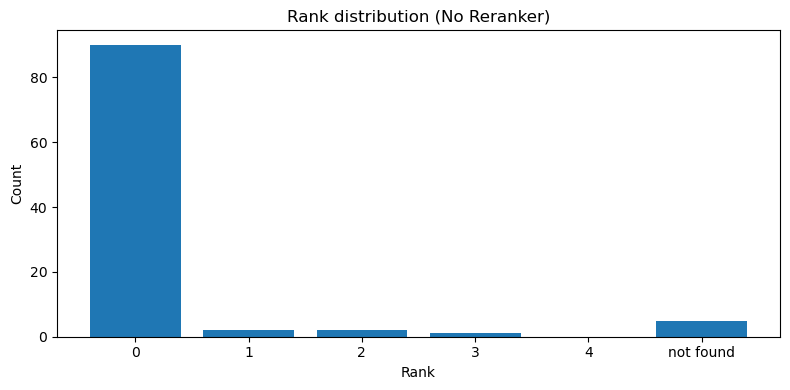

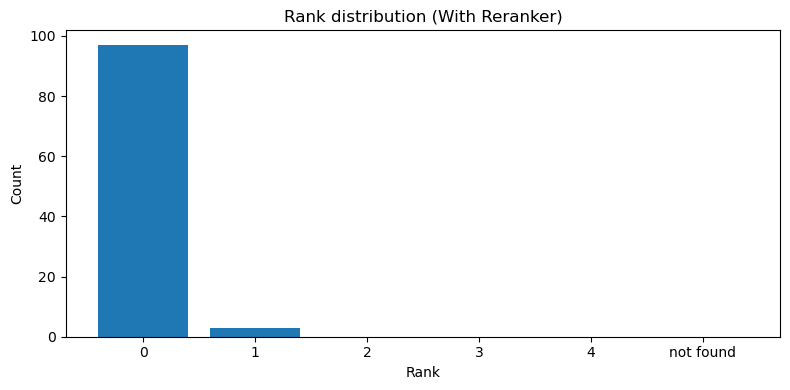


Summary:
       metric  no_reranker  with_reranker  delta (with - no)
avg_position     0.094737           0.03          -0.064737
  median_pos     0.000000           0.00           0.000000
   top1_rate     0.900000           0.97           0.070000
   top2_rate     0.920000           1.00           0.080000

Change breakdown
tied                        88
found_only_with_reranker     5
improved                     5
worse                        2


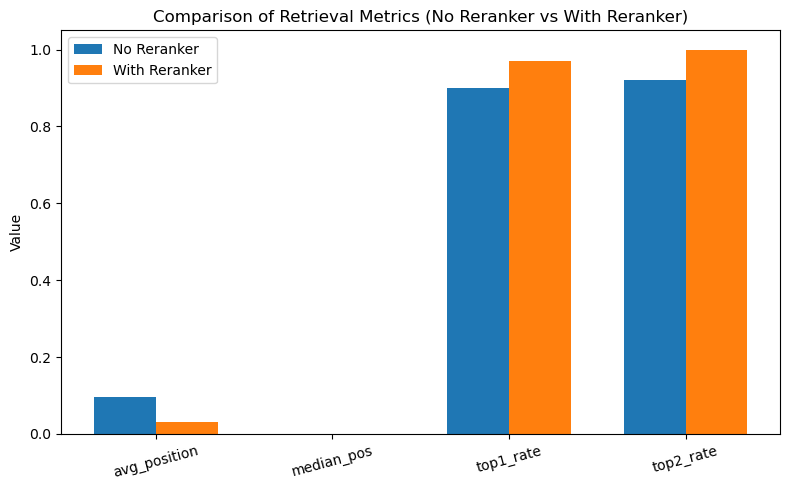

In [20]:
# CSV READ AND MERGE
no  = pd.read_csv("df_eval_no_reranker.csv")
rr  = pd.read_csv("df_eval_with_reranker.csv")[["QUESTION","NEWS","WITH_RERANKER"]]
cmp = no.merge(rr, on=["QUESTION","NEWS"], how="inner")

cmp["no_rr_num"] = pd.to_numeric(cmp["NO_RERANKER"], errors="coerce")
cmp["rr_num"]    = pd.to_numeric(cmp["WITH_RERANKER"], errors="coerce")

# METRICS
def metrics(s: pd.Series):
    s = s.copy()
    return {
        "avg_position" : s.mean(),                        
        "median_pos"   : s.median(),
        "top1_rate"    : (s == 0).mean(),  
        "top2_rate"    : (s <= 1).mean(),                 
    }

m_no = metrics(cmp["no_rr_num"])
m_rr = metrics(cmp["rr_num"])

def plot_dist(col, title):
    order = [str(i) for i in range(5)] + ["not found"]
    counts = cmp[col].astype(str).replace({"nan":"not found"}).value_counts()
    counts = counts.reindex(order).fillna(0)
    plt.figure(figsize=(8,4))
    plt.bar(counts.index, counts.values)
    plt.title(title); plt.xlabel("Rank"); plt.ylabel("Count")
    plt.xticks(rotation=0); plt.tight_layout(); plt.show()

plot_dist("NO_RERANKER",  "Rank distribution (No Reranker)")
plot_dist("WITH_RERANKER","Rank distribution (With Reranker)")


summary = pd.DataFrame({
    "metric": ["avg_position","median_pos","top1_rate","top2_rate"],
    "no_reranker": [m_no[k] for k in ["avg_position","median_pos","top1_rate","top2_rate"]],
    "with_reranker": [m_rr[k] for k in ["avg_position","median_pos","top1_rate","top2_rate"]],
})
summary["delta (with - no)"] = summary["with_reranker"] - summary["no_reranker"]
print("\nSummary:\n", summary.to_string(index=False))

no_num, rr_num = cmp["no_rr_num"], cmp["rr_num"]
change = pd.Series("other", index=cmp.index)
change.loc[ no_num.isna() & rr_num.notna() ] = "found_only_with_reranker"
change.loc[ no_num.notna() & rr_num.isna() ] = "lost_with_reranker"
both = no_num.notna() & rr_num.notna()
change.loc[ both & (rr_num <  no_num) ] = "improved"
change.loc[ both & (rr_num == no_num) ] = "tied"
change.loc[ both & (rr_num >  no_num) ] = "worse"
change.loc[ no_num.isna() & rr_num.isna() ] = "both_not_found"

counts = change.value_counts()
share  = (counts / len(change)).apply(lambda x: f"{x:.1%}")
print("\nChange breakdown")
print(counts.to_string())


metric_names = summary["metric"].tolist()
no_vals = summary["no_reranker"].values
rr_vals = summary["with_reranker"].values

x = range(len(metric_names))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar([i - width/2 for i in x], no_vals, width, label="No Reranker")
plt.bar([i + width/2 for i in x], rr_vals, width, label="With Reranker")
plt.xticks(list(x), metric_names, rotation=15)
plt.ylabel("Value")
plt.title("Comparison of Retrieval Metrics (No Reranker vs With Reranker)")
plt.legend()
plt.tight_layout()
plt.show()

### **Question 1.** Did reranking improve the **average position** of the correct news?
 


_Yes, it did, in my case excluding not found cases, the average position is 0.094 with reranking
without reranking, the average position is 0.03_

### **Question 2.** How often was the correct article at **position 0** with and without reranking?



_Yes it did, in my case without the reranker, 92% are in position 0 and 1, where as 100% are in position 0 and 1 with the reranker_